# **Algoritmo SVD**

**Miembros del grupo JAP:**
1. Anny Álvarez Nogales
2. Paula Arias Fernández
3. Jorge del Castillo Gómez
---
El algoritmo SVD (Singular Value Decomposition) de recomendación es una técnica utilizada principalmente en sistemas de recomendación para predecir las valoraciones o preferencias de un usuario sobre ítems que no ha visto o calificado. SVD es un enfoque basado en factorización matricial, que descompone una matriz de interacciones (por ejemplo, una matriz de usuarios vs ítems con sus valoraciones) en tres matrices más pequeñas que capturan características latentes de los usuarios y los ítems.

## **¿Cómo funciona el SVD en un sistema de recomendación?**

Supón que tenemos una matriz \( R \) de **valoraciones** (ratings), donde las filas representan a los **usuarios** y las columnas representan a los **ítems**.

Las celdas de la matriz contienen las valoraciones que los usuarios han dado a los ítems. Sin embargo, esta matriz es generalmente muy dispersa, ya que los usuarios solo valoran una pequeña fracción de los ítems disponibles.

#### **Descomposición**:
El algoritmo SVD descompone la matriz de valoraciones \( R \) en tres matrices:
- **U (usuarios)**: Una matriz de características latentes de los usuarios (\( m \times k \), donde \( m \) es el número de usuarios y \( k \) es el número de características latentes).
- **Σ (singular values)**: Una matriz diagonal (\( k \times k \)) con los valores singulares que representan la importancia de las características latentes.
- **\( V^T \) (ítems)**: Una matriz de características latentes de los ítems (\( k \times n \), donde \( n \) es el número de ítems).

La descomposición completa es:
\[
R \approx U \cdot \Sigma \cdot V^T
\]
- \( R \) es la matriz original de valoraciones.
- \( U \) es la matriz de usuarios con las características latentes de los usuarios.
- \( \Sigma \) es la matriz de los valores singulares que representa la importancia de cada característica latente.
- \( V^T \) es la matriz transpuesta de ítems con las características latentes de los ítems.

#### **Predicción**:
La idea principal de SVD es **predecir las valoraciones faltantes** en la matriz \( R \), es decir, aquellas celdas en las que el usuario aún no ha dado una valoración. Para ello, una vez descompuesta la matriz \( R \), el modelo puede usar la multiplicación de las matrices \( U \cdot \Sigma \cdot V^T \) para aproximar las valoraciones que el usuario podría dar a ítems no valorados.

#### **Optimización**:
En la práctica, los algoritmos de SVD como **SVD++** o **SVD de baja regularización** no simplemente calculan la descomposición, sino que también **optimizan los parámetros** mediante técnicas de aprendizaje automático como el **descenso por gradiente**. El objetivo es minimizar la diferencia entre las valoraciones predichas y las valoraciones reales (si están disponibles).

#### **Regularización**:
Dado que la matriz \( R \) puede ser muy dispersa y los modelos SVD pueden sobreajustar (overfitting) a los datos, se aplica **regularización** para evitar que el modelo se ajuste demasiado a las peculiaridades de los datos de entrenamiento. La regularización agrega un término al error de predicción que penaliza los valores grandes en las matrices \( U \), \( \Sigma \) y \( V \).


## **Reader Dataset**

In [2]:
%pip install scikit-surprise --quiet

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import os
import random
import operator
import requests
import numpy as np
import pandas as pd
from scipy import sparse
import sys
from surprise import Dataset, Reader
from surprise import KNNBasic, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.dataset import DatasetAutoFolds
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.special import digamma
from math import exp

df_train = pd.read_csv('train.csv', sep=',', index_col=False)
df_test = pd.read_csv('test.csv', sep=',', index_col=False)


In [4]:
df_train.head(5)

,user,item,rating
0,1,25715,7.0
1,1,25716,10.0
2,5,25851,9.0
3,6,25923,5.0
4,7,25924,6.0


In [7]:
reader = Reader(rating_scale=(0,10)) # rating scale range
data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


In [8]:
trainset, testset = train_test_split(data, test_size=0.25)
print(type(trainset))

<class 'surprise.trainset.Trainset'>


In [8]:
trainset = data.build_full_trainset()

### **Análisis exploratorio de los datos**

Métricas estadísticas:
Media: 7.604666056958993
Desviación estándar: 1.8427925448562066
Varianza: 3.395884363377614
Valor mínimo: 1.0
Valor máximo: 10.0
Mediana: 8.0
Percentiles (25%, 50%, 75%): [7. 8. 9.]


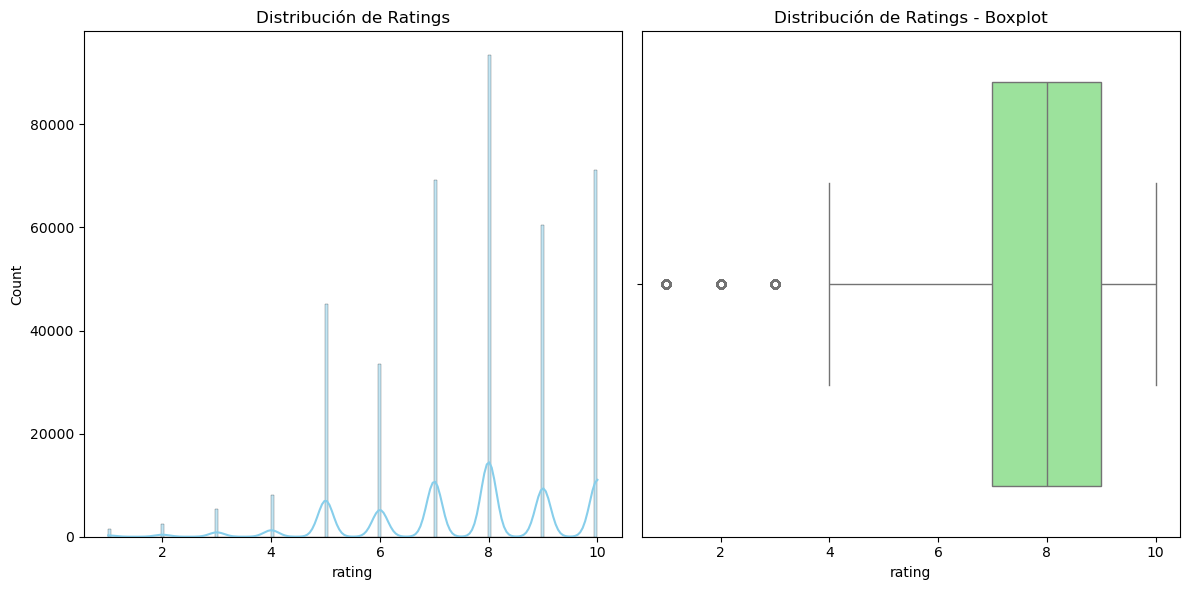

In [2]:
media = df_train['rating'].mean()
desviacion = df_train['rating'].std()
varianza = df_train['rating'].var()
minimo = df_train['rating'].min()
maximo = df_train['rating'].max()
mediana = df_train['rating'].median()
percentiles = np.percentile(df_train['rating'], [25, 50, 75])


print("Métricas estadísticas:")
print(f"Media: {media}")
print(f"Desviación estándar: {desviacion}")
print(f"Varianza: {varianza}")
print(f"Valor mínimo: {minimo}")
print(f"Valor máximo: {maximo}")
print(f"Mediana: {mediana}")
print(f"Percentiles (25%, 50%, 75%): {percentiles}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_train['rating'], kde=True, color='skyblue')
plt.title('Distribución de Ratings')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_train['rating'], color='lightgreen')
plt.title('Distribución de Ratings - Boxplot')

plt.tight_layout()
plt.show()

Las gráficas indican que la mayoría de ratings se concentran en valores altos, en torno a 6 y 10 de valoración.

## **Algoritmo**

In [31]:
algo = SVD()
algo.fit(trainset)

In [32]:
predictions = algo.test(testset)

In [33]:
accuracy.mae(predictions)

MAE:  0.7635


0.7634623190271725

> Exportacion de predicciones.csv

In [34]:
testset[0:5]

[(3891, 81714, 10.0),
 (49435, 77613, 8.0),
 (38654, 112871, 6.0),
 (69560, 55505, 10.0),
 (69799, 28638, 9.0)]

In [35]:
solution = []

for _, row in df_test.iterrows():
    user = row['user']
    item = row['item']
    
    pred = algo.predict(user, item).est  # Predicción de rating
    solution.append([row['ID'], pred])

solution_df = pd.DataFrame(solution, columns=["ID", "rating"])

solution_df.to_csv('predictions_svd.csv', index=False)


Esta primera ejecución SVD devuelve un MAE: 1.263.

En las siguientes celdas se aplica **GridSearch** de SVD para ajustar los hiperparametros. El siguiente primer GridSearch es general, sobre los parámetros más importantes de SVD: *[n_factors, n_epochs, lr_all, reg_all]*

In [ ]:
import os
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV

output_dir = "predictions/svd_gridsearch"
os.makedirs(output_dir, exist_ok=True)


reader = Reader(rating_scale=(df_train["rating"].min(), df_train["rating"].max()))
data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)

param_grid = {
    "n_factors": [50, 100, 150],     # complejidad
    "n_epochs": [20, 30, 50],        
    "lr_all": [0.002, 0.005, 0.01],  #  tasa de aprendizaje
    "reg_all": [0.02, 0.04, 0.06],   # Regularización
}

grid_search = GridSearchCV(SVD, param_grid, measures=["mae"], cv=3, n_jobs=-1, joblib_verbose=1)
grid_search.fit(data)

best_params = grid_search.best_params["mae"]
print(f"Mejores parámetros: {best_params}")

### ENTRENO  EL MEJOR MODELO CON TODOS LOS DATOS
best_svd = SVD(**best_params, random_state=42)
trainset = data.build_full_trainset()
best_svd.fit(trainset)

solution = []
for _, row in df_test.iterrows():
    user = row["user"]
    item = row["item"]
    pred = best_svd.predict(user, item).est
    solution.append([row["ID"], pred])


output_file = os.path.join(output_dir, "predictions_svd.csv")
solution_df = pd.DataFrame(solution, columns=["ID", "rating"])
solution_df.to_csv(output_file, index=False)

print(f"Predicciones guardadas en {output_file}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 15.0min finished


Mejores parámetros: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.06}
Predicciones guardadas en svd_gridsearch\predictions_svd.csv


A partir de la mejor solución anterior, con un MAE: 1.260 (Mejores parámetros: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.06}), se vuelve a ejecutar un segundo GridSearch para refinar los parámetros.

In [ ]:
param_grid = {
    "n_factors": [40, 50, 60],       
    "n_epochs": [25, 30, 35],        
    "lr_all": [0.004, 0.005, 0.006], 
    "reg_all": [0.05, 0.06, 0.07],  
    "biased": True,
    
}

algo = SVD()
grid_search = GridSearchCV(SVD, param_grid, measures=["mae"], cv=3, n_jobs=-1, joblib_verbose=1)
grid_search.fit(data)

best_params = grid_search.best_params["mae"]
print(f"Mejores parámetros: {best_params}")

best_svd = SVD(**best_params, random_state=42)
trainset = data.build_full_trainset()
best_svd.fit(trainset)

solution = []
for _, row in df_test.iterrows():
    user = row["user"]
    item = row["item"]
    pred = best_svd.predict(user, item).est
    solution.append([row["ID"], pred])

output_file = os.path.join(output_dir, "predictions_svd_grid2.csv")
solution_df = pd.DataFrame(solution, columns=["ID", "rating"])
solution_df.to_csv(output_file, index=False)

print(f"Predicciones guardadas en {output_file}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  9.5min finished


Mejores parámetros: {'n_factors': 40, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}
Predicciones guardadas en predictions/svd_gridsearch\predictions_svd_grid2.csv


A continuación, se busca afinar la solución anterior con MAE: 1.262 (Mejores parámetros: {'n_factors': 40, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}) en base a nuevos parámetros: *[lr y reg]*


In [ ]:
import os
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV

output_dir = "predictions/svd_gridsearch"
os.makedirs(output_dir, exist_ok=True)

reader = Reader(rating_scale=(df_train["rating"].min(), df_train["rating"].max()))
data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)

param_grid = {
    "n_factors": [50],  
    "n_epochs": [30],   
    "lr_all": [0.005],  
    "reg_all": [0.06],  

    "lr_bu": [0.002, 0.005],  
    "lr_bi": [0.002, 0.005],  
    "lr_pu": [0.002, 0.005],  
    "lr_qi": [0.002, 0.005],  

    "reg_bu": [0.02, 0.04],   
    "reg_bi": [0.02, 0.04],   
}

algo = SVD()
grid_search = GridSearchCV(SVD, param_grid, measures=["mae"], cv=3, n_jobs=-1, joblib_verbose=1)
grid_search.fit(data)

best_params = grid_search.best_params["mae"]
print(f"Mejores parámetros: {best_params}")

best_svd = SVD(**best_params, random_state=42)
trainset = data.build_full_trainset()
best_svd.fit(trainset)

solution = []
for _, row in df_test.iterrows():
    user = row["user"]
    item = row["item"]
    pred = best_svd.predict(user, item).est
    solution.append([row["ID"], pred])

output_file = os.path.join(output_dir, "predictions_svd3.csv")
solution_df = pd.DataFrame(solution, columns=["ID", "rating"])
solution_df.to_csv(output_file, index=False)

print(f"Predicciones guardadas en {output_file}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  7.2min finished


Mejores parámetros: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.06, 'lr_bu': 0.005, 'lr_bi': 0.005, 'lr_pu': 0.002, 'lr_qi': 0.002, 'reg_bu': 0.02, 'reg_bi': 0.04}
Predicciones guardadas en predictions/svd_gridsearch\predictions_svd3.csv


Esta nueva solución con un MAE de 1.250 (Mejores parámetros: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.06, 'lr_bu': 0.005, 'lr_bi': 0.005, 'lr_pu': 0.002, 'lr_qi': 0.002, 'reg_bu': 0.02, 'reg_bi': 0.04}) se refina de nuevo por los parámetros *[lr y reg]*

In [ ]:
import os
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV

output_dir = "predictions/svd_gridsearch"
os.makedirs(output_dir, exist_ok=True)

reader = Reader(rating_scale=(df_train["rating"].min(), df_train["rating"].max()))
data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)

param_grid = {
    "n_factors": [50],  
    "n_epochs": [30],   
    "lr_all": [0.005],  
    "reg_all": [0.06],  

    "lr_bu": [0.005, 0.01],  
    "lr_bi": [0.005, 0.01],  
    "lr_pu": [0.002, 0.001],  
    "lr_qi": [0.002, 0.001],  

    "reg_bu": [0.02, 0.04],   
    "reg_bi": [0.02, 0.04],   
}

algo = SVD()
grid_search = GridSearchCV(SVD, param_grid, measures=["mae"], cv=3, n_jobs=-1, joblib_verbose=1)
grid_search.fit(data)

best_params = grid_search.best_params["mae"]
print(f"Mejores parámetros: {best_params}")

best_svd = SVD(**best_params, random_state=42)
trainset = data.build_full_trainset()
best_svd.fit(trainset)

solution = []
for _, row in df_test.iterrows():
    user = row["user"]
    item = row["item"]
    pred = best_svd.predict(user, item).est
    solution.append([row["ID"], pred])

output_file = os.path.join(output_dir, "predictions_svd4.csv")
solution_df = pd.DataFrame(solution, columns=["ID", "rating"])
solution_df.to_csv(output_file, index=False)

print(f"Predicciones guardadas en {output_file}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  6.4min finished


Mejores parámetros: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.06, 'lr_bu': 0.01, 'lr_bi': 0.005, 'lr_pu': 0.001, 'lr_qi': 0.002, 'reg_bu': 0.02, 'reg_bi': 0.02}
Predicciones guardadas en predictions/svd_gridsearch\predictions_svd4.csv


La solución anterior con un MAE DE 1.242 (Mejores parámetros: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.06, 'lr_bu': 0.01, 'lr_bi': 0.005, 'lr_pu': 0.001, 'lr_qi': 0.002, 'reg_bu': 0.02, 'reg_bi': 0.02}) se termina de ajustar con el ajuste de Epochs y n_factors.

In [ ]:
import os
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV

output_dir = "predictions/svd_gridsearch"
os.makedirs(output_dir, exist_ok=True)

reader = Reader(rating_scale=(df_train["rating"].min(), df_train["rating"].max()))
data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)

param_grid = {
    "n_factors": [45, 50, 55],  
    "n_epochs": [25, 30, 35],   
    "lr_all": [0.005],          
    "reg_all": [0.06],         

    "lr_bu": [0.01, 0.015],      
    "lr_bi": [0.005],           
    "lr_pu": [0.001],          
    "lr_qi": [0.002],           

    "reg_bu": [0.02],           
    "reg_bi": [0.02],           
}

algo = SVD()
grid_search = GridSearchCV(SVD, param_grid, measures=["mae"], cv=4, n_jobs=-1, joblib_verbose=1)
grid_search.fit(data)

best_params = grid_search.best_params["mae"]
print(f"Mejores parámetros: {best_params}")

best_svd = SVD(**best_params, random_state=42)
trainset = data.build_full_trainset()
best_svd.fit(trainset)

solution = []
for _, row in df_test.iterrows():
    user = row["user"]
    item = row["item"]
    pred = best_svd.predict(user, item).est
    solution.append([row["ID"], pred])

output_file = os.path.join(output_dir, "predictions_svd5.csv")
solution_df = pd.DataFrame(solution, columns=["ID", "rating"])
solution_df.to_csv(output_file, index=False)

print(f"Predicciones guardadas en {output_file}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.6min finished


Mejores parámetros: {'n_factors': 45, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.06, 'lr_bu': 0.015, 'lr_bi': 0.005, 'lr_pu': 0.001, 'lr_qi': 0.002, 'reg_bu': 0.02, 'reg_bi': 0.02}
Predicciones guardadas en predictions/svd_gridsearch\predictions_svd5.csv


La configuración de parámetros ideal es 
`{   'n_factors': 45, 
    'n_epochs': 25, 
    'lr_all': 0.005, 
    'reg_all': 0.06, 
    'lr_bu': 0.015, 
    'lr_bi': 0.005, 
    'lr_pu': 0.001, 
    'lr_qi': 0.002, 
    'reg_bu': 0.02, 
    'reg_bi': 0.02   }.` 